# Compare NLP Techniques

### Prep The Data For Modeling

#### Read In & Clean Text

In [4]:
# Read in and clean data
import nltk
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import string

nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lsoares\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
messages = pd.read_csv('data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
messages['label'] = np.where(messages['label']=='spam', 1, 0)

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

messages['clean_text'] = messages['text'].apply(lambda x: clean_text(x))
messages.head()

,label,text,clean_text
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t..."


In [6]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(messages['clean_text'],  # Feature data: the clean_text messages
                                                    messages['label'],       # Target data: the corresponding labels (0 for ham, 1 for spam)
                                                    test_size=0.2)           # 20% of the data will be used for testing

In [7]:
# What do the first ten messages in the training set look like?
X_train[:10]

885                           [gibbs, unsoldmike, hussey]
1402    [registered, sinco, payee, log, icicibankcom, ...
1371    [though, shd, go, n, fun, bar, town, something...
1683              [already, squatting, new, way, walking]
1214       [ill, text, creepy, like, wont, think, forgot]
2199                                    [sure, stomach, ]
2453                               [much, payed, suganya]
3394                                                [buy]
2909                        [guys, go, see, movies, side]
2701    [hiya, sorry, didnt, hav, signal, havent, seen...
Name: clean_text, dtype: object

In [8]:
# What do the labels look like?
y_train[:10]

885     0
1402    0
1371    0
1683    0
1214    0
2199    0
2453    0
3394    0
2909    0
2701    0
Name: label, dtype: int32

In [9]:
# Let's save the training and test sets to ensure we are using the same data for each model
X_train.to_csv('data/X_train1.csv', index=False,header=True )
X_test.to_csv('data/X_test1.csv', index=False,header=True)
y_train.to_csv('data/y_train1.csv', index=False,header=True)
y_test.to_csv('data/y_test1.csv', index=False,header=True)

## Build Model On TF-IDF Vectors

#### Read In Cleaned Text

In [12]:
X_train = pd.read_csv('data/X_train1.csv')
X_test = pd.read_csv('data/X_test1.csv')
y_train = pd.read_csv('data/y_train1.csv')
y_test = pd.read_csv('data/y_test1.csv')

X_train.head()

,clean_text
0,"['gibbs', 'unsoldmike', 'hussey']"
1,"['registered', 'sinco', 'payee', 'log', 'icici..."
2,"['though', 'shd', 'go', 'n', 'fun', 'bar', 'to..."
3,"['already', 'squatting', 'new', 'way', 'walking']"
4,"['ill', 'text', 'creepy', 'like', 'wont', 'thi..."


#### Create TF-IDF Vectors

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate and fit a TFIDF vectorizer and then use that trained vectorizer to transform the messages in the training and test sets

tfidf_vect = TfidfVectorizer()                              # Initialize the TF-IDF vectorizer
tfidf_vect.fit(X_train['clean_text'])                       # Fit the vectorizer on the training data
X_train_vect = tfidf_vect.transform(X_train['clean_text'])  # Transform the training data into TF-IDF features
X_test_vect = tfidf_vect.transform(X_test['clean_text'])    # Transform the test data into TF-IDF features

In [15]:
# What words did the vectorizer learn?
#tfidf_vect.vocabulary_

In [16]:
# How are these vectors stored?
X_test_vect[0]

<1x8237 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

A very sparse matrix!

In [18]:
# Can we convert the vectors to arrays?
X_test_vect[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

#### Fit RandomForestClassifier On Top Of Vectors

In [20]:
# Fit a basic Random Forest model on these vectors
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()              # Initialize the RandomForestClassifier model

rf_model = rf.fit(X_train_vect,            # Fit the RandomForestClassifier on the training data
                  y_train.values.ravel())  # Flatten y_train to ensure it's a 1D array for the model (Pandas to array)

In [21]:
# Use the trained model to make predictions on the test data
y_pred=rf_model.predict(X_test_vect)

In [22]:
# Evaluate the predictions of the model on the holdout test set
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test,   # True labels for the test set
                            y_pred)   # Predicted labels by the model

recall = recall_score(y_test,   # True labels for the test set
                      y_pred)   # Predicted labels by the model

print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3),                                     # Round precision to 3 decimal places
    round(recall, 3),                                        # Round recall to 3 decimal places
    round((y_pred==y_test['label']).sum()/len(y_pred), 3)))  # Round accuracy to 3 decimal places

Precision: 1.0 / Recall: 0.796 / Accuracy: 0.97


* So one hundred percent **precision** means that when the model identified a text message in the test set as spam, it actually was spam 100% of the time.

* 76.3% **recall** means that, of the title messages in the test set that were labeled as spam, the model correctly identified 76.3% of them. In other words, the other 23.7% of them, the model thought was not spam. 

* Lastly, 96.7% **accuracy**, just means that whether the model predicted spam or not, it was correct 96.7% of the time. 

So on the surface, these metrics look really good. This looks like a nice baseline to set. So now let's explore other methods to see if any of them can be our baseline.

## Build Model on Word2Vec Vectors

#### Create word2vec Vectors

In [26]:
import gensim

w2v_model = gensim.models.Word2Vec(X_train,         # Train the Word2Vec model using the training data
                                   vector_size=100, # Dimensionality of the word vectors
                                   window=5,        # Maximum distance between the current and predicted word within a sentence
                                   min_count=2)     # Ignores all words with a total frequency lower than this

In [27]:
# Replace the words in each text message with the learned word vector
words = set(w2v_model.wv.index_to_key)

X_train_vect = [
    [w2v_model.wv[word] for word in text if word in w2v_model.wv.key_to_index]  # Extract word vectors for each word in the message
    for text in X_train['clean_text']                                            # Iterate over each message in X_test['clean_text']
]
X_test_vect = [
    [w2v_model.wv[word] for word in text if word in w2v_model.wv.key_to_index]  # Extract word vectors for each word in the message
    for text in X_test['clean_text']                                            # Iterate over each message in X_test['clean_text']
]

In [28]:
# Average the word vectors for each message, or assign a vector of zeros if the list is empty
X_train_vect_avg = []

for v in X_train_vect:
    if len(v) > 0:                                           # Check if the list of vectors is not empty
        X_train_vect_avg.append(np.mean(v, axis=0))          # Calculate the mean of the vectors
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))  # Assign a zero vector if no words found

X_test_vect_avg = []
for v in X_test_vect:
    if len(v) > 0:                                           # Check if the list of vectors is not empty
        X_test_vect_avg.append(np.mean(v, axis=0))           # Calculate the mean of the vectors
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))   # Assign a zero vector if no words found

In [29]:
# What does the unaveraged version look like?
X_test_vect[0]  # one array to each vector ("word") in the first message

[array([-8.6196875e-03,  3.6657380e-03,  5.1898835e-03,  5.7419385e-03,
         7.4669183e-03, -6.1676754e-03,  1.1056137e-03,  6.0472824e-03,
        -2.8400505e-03, -6.1735227e-03, -4.1022300e-04, -8.3689485e-03,
        -5.6000124e-03,  7.1045388e-03,  3.3525396e-03,  7.2256695e-03,
         6.8002474e-03,  7.5307419e-03, -3.7891543e-03, -5.6180597e-04,
         2.3483764e-03, -4.5190323e-03,  8.3887316e-03, -9.8581640e-03,
         6.7646410e-03,  2.9144168e-03, -4.9328315e-03,  4.3981876e-03,
        -1.7395747e-03,  6.7113843e-03,  9.9648498e-03, -4.3624435e-03,
        -5.9933780e-04, -5.6956373e-03,  3.8508223e-03,  2.7866268e-03,
         6.8910765e-03,  6.1010956e-03,  9.5384968e-03,  9.2734173e-03,
         7.8980681e-03, -6.9895042e-03, -9.1558648e-03, -3.5575271e-04,
        -3.0998408e-03,  7.8943167e-03,  5.9385742e-03, -1.5456629e-03,
         1.5109634e-03,  1.7900408e-03,  7.8175711e-03, -9.5101865e-03,
        -2.0553112e-04,  3.4691966e-03, -9.3897223e-04,  8.38177

In [30]:
# What does the averaged version look like?
X_test_vect_avg[0]

array([-7.2724447e-03,  3.0941870e-03,  5.1754615e-03,  6.2864944e-03,
        4.6719401e-03, -6.3258647e-03,  1.9978236e-03,  6.5349001e-03,
       -3.2026134e-03, -5.7718307e-03,  8.8823168e-04, -7.2297021e-03,
       -5.4227789e-03,  7.0127905e-03,  1.9837562e-03,  5.7187215e-03,
        6.1463029e-03,  6.4409305e-03, -4.5384979e-03, -2.0429748e-03,
        3.1756079e-03, -2.9208167e-03,  8.1168925e-03, -8.0879927e-03,
        6.6956826e-03,  1.8611196e-03, -4.2684269e-03,  4.6265852e-03,
       -2.7032520e-03,  4.9368031e-03,  7.0521110e-03, -3.7903765e-03,
        1.0902383e-03, -5.9662256e-03,  2.8200571e-03,  1.9992322e-03,
        7.0888028e-03,  4.0957639e-03,  7.9562748e-03,  6.9355587e-03,
        4.9811318e-03, -4.9900380e-03, -9.0898192e-03, -1.0284315e-03,
       -2.5890509e-03,  6.5292330e-03,  3.6719386e-03,  3.1440475e-04,
        2.0894792e-03,  3.0305579e-03,  5.1549897e-03, -7.1758553e-03,
       -8.6078863e-04,  3.0284200e-03,  6.3395983e-04,  6.2411143e-03,
      

#### Another version

In [32]:
# Replace the words in each text message with the learned word vector
words = set(w2v_model.wv.index_to_key)


# Helper function to average word vectors for each message
def average_word_vectors(words_list, model, num_features):    # Define a function that takes a list of words, the model, and the number of features
    
    # Initialize an array of zeros
    feature_vec = np.zeros((num_features,), dtype="float32")  # Create a zero vector with a size equal to the number of features
    n_words = 0                                               # Initialize the word count to zero
    
    # Iterate over the words in the words_list
    for word in words_list:                                   # Loop through each word in the provided list
        if word in model.wv.key_to_index:                     # Check if the word exists in the model's vocabulary
            feature_vec = np.add(feature_vec, model.wv[word]) # Add the vector of the word to the feature vector
            n_words += 1                                      # Increment the word count
    
    # Divide the sum of vectors by the number of words to get the average
    if n_words > 0:                                           # Check if any words were added
        feature_vec = np.divide(feature_vec, n_words)         # Calculate the average by dividing the feature vector by the word count
    
    return feature_vec                                        # Return the averaged vector


# Apply the function to transform training and test sets
X_train_vect_aveg = np.array([average_word_vectors(                # Transform the training set by averaging the word vectors for each text message
                                                   text,           # Pass each cleaned text message from X_train
                                                   w2v_model,      # Use the trained Word2Vec model
                                                   100             # Set the number of features to match the vector size used in training
                                                   ) for text in X_train['clean_text']])

X_test_vect_avg = np.array([average_word_vectors(                 # Transform the test set by averaging the word vectors for each text message
                                                 text,            # Pass each cleaned text message from X_test
                                                 w2v_model,       # Use the trained Word2Vec model
                                                 100              # Set the number of features to match the vector size used in training
                                                ) for text in X_test['clean_text']])

X_test_vect_avg[0]

array([-7.2724447e-03,  3.0941870e-03,  5.1754615e-03,  6.2864944e-03,
        4.6719401e-03, -6.3258647e-03,  1.9978236e-03,  6.5349001e-03,
       -3.2026134e-03, -5.7718307e-03,  8.8823168e-04, -7.2297021e-03,
       -5.4227789e-03,  7.0127905e-03,  1.9837562e-03,  5.7187215e-03,
        6.1463029e-03,  6.4409305e-03, -4.5384979e-03, -2.0429748e-03,
        3.1756079e-03, -2.9208167e-03,  8.1168925e-03, -8.0879927e-03,
        6.6956826e-03,  1.8611196e-03, -4.2684269e-03,  4.6265852e-03,
       -2.7032520e-03,  4.9368031e-03,  7.0521110e-03, -3.7903765e-03,
        1.0902383e-03, -5.9662256e-03,  2.8200571e-03,  1.9992322e-03,
        7.0888028e-03,  4.0957639e-03,  7.9562748e-03,  6.9355587e-03,
        4.9811318e-03, -4.9900380e-03, -9.0898192e-03, -1.0284315e-03,
       -2.5890509e-03,  6.5292330e-03,  3.6719386e-03,  3.1440475e-04,
        2.0894792e-03,  3.0305579e-03,  5.1549897e-03, -7.1758553e-03,
       -8.6078863e-04,  3.0284200e-03,  6.3395983e-04,  6.2411143e-03,
      

#### Fit RandomForestClassifier On Top Of Word Vectors

In [34]:
# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()  # Initialize the Random Forest Classifier model

rf_model = rf.fit(X_train_vect_avg,             # Fit the model using the averaged word vectors from the training data
                  y_train.values.ravel())       # Use the training labels, flattened to a 1D array

In [35]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

In [36]:
rf = RandomForestClassifier()              # Initialize the RandomForestClassifier model

rf_model = rf.fit(X_train_vect_avg,       # Fit the RandomForestClassifier on the training data
                  y_train.values.ravel())  # Flatten y_train to ensure it's a 1D array for the model (Pandas to array)

In [37]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

In [38]:
precision = precision_score(y_test,   # True labels for the test set
                            y_pred)   # Predicted labels by the model

recall = recall_score(y_test,   # True labels for the test set
                      y_pred)   # Predicted labels by the model

print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3),                                     # Round precision to 3 decimal places
    round(recall, 3),                                        # Round recall to 3 decimal places
    round((y_pred==y_test['label']).sum()/len(y_pred), 3)))  # Round accuracy to 3 decimal places

Precision: 0.508 / Recall: 0.198 / Accuracy: 0.856


Now looking at these, we can see that the results are quite a bit worse than our TFIDF baseline. We got worse precision, recall and accuracy. This kind of makes sense, as the main drawback with word2vec is that it's not really intended to create representations of sentences. We're just crudely averaging across word vectors to get a sentence or text level representation, but that loses information. So let's jump into doc2vec to see if that will solve this issue.

## Build Model On doc2vec Vectors

#### Create doc2vec Vectors

In [42]:
# Create TaggedDocument vectors for each text message in the training set
tagged_docs_train = [gensim.models.doc2vec.TaggedDocument(v, [i])  # Create a TaggedDocument for each message
                     for i, v in enumerate(X_train['clean_text'])]  # Enumerate over the training data to tag each document

# Create TaggedDocument vectors for each text message in the test set
tagged_docs_test = [gensim.models.doc2vec.TaggedDocument(v, [i])   # Create a TaggedDocument for each message
                    for i, v in enumerate(X_test['clean_text'])]   # Enumerate over the test data to tag each document

In [43]:
# What do these TaggedDocument objects look like?
tagged_docs_train[:10]

[TaggedDocument(words="['gibbs', 'unsoldmike', 'hussey']", tags=[0]),
 TaggedDocument(words="['registered', 'sinco', 'payee', 'log', 'icicibankcom', 'enter', 'urn', 'ltgt', 'confirm', 'beware', 'frauds', 'share', 'disclose', 'urn', 'anyone']", tags=[1]),
 TaggedDocument(words="['though', 'shd', 'go', 'n', 'fun', 'bar', 'town', 'something', 'ûò', 'sound', 'ok']", tags=[2]),
 TaggedDocument(words="['already', 'squatting', 'new', 'way', 'walking']", tags=[3]),
 TaggedDocument(words="['ill', 'text', 'creepy', 'like', 'wont', 'think', 'forgot']", tags=[4]),
 TaggedDocument(words="['sure', 'stomach', '']", tags=[5]),
 TaggedDocument(words="['much', 'payed', 'suganya']", tags=[6]),
 TaggedDocument(words="['buy']", tags=[7]),
 TaggedDocument(words="['guys', 'go', 'see', 'movies', 'side']", tags=[8]),
 TaggedDocument(words="['hiya', 'sorry', 'didnt', 'hav', 'signal', 'havent', 'seen', 'heard', 'neither', 'unusual', 'ill', 'put', 'case', 'get', 'sort', 'hugs', 'snogs']", tags=[9])]

In [44]:
# Train a basic Doc2Vec model on the tagged documents from the training set
d2v_model = gensim.models.Doc2Vec(tagged_docs_train,  # Train the model using the tagged documents
                                  vector_size=100,    # Dimensionality of the document vectors
                                  window=5,           # Maximum distance between the current and predicted word within a sentence
                                  min_count=2)        # Ignores all words with a total frequency lower than this

In [45]:
# Infer the document vectors for the training set
train_vectors = [d2v_model.infer_vector(eval(v.words))  # Infer the vector for each document in the training set
                 for v in tagged_docs_train]           # Iterate over each TaggedDocument in the training set

# Infer the document vectors for the test set
test_vectors = [d2v_model.infer_vector(eval(v.words))   # Infer the vector for each document in the test set
                for v in tagged_docs_test]            # Iterate over each TaggedDocument in the test set

# Display the inferred vector for the first document in the test set
test_vectors[0]

array([ 4.7672335e-03, -1.1756722e-03,  1.1442238e-03, -3.7218301e-04,
       -1.6132352e-03, -3.1529861e-03,  1.3237972e-03, -2.1742838e-03,
        3.8445056e-03,  4.5284010e-03, -1.6682592e-03,  2.1407707e-03,
       -1.8076327e-03, -4.4403775e-03,  1.0928428e-03,  4.8687998e-03,
        3.7439661e-03, -1.8703511e-03, -1.6877562e-04, -1.6261700e-03,
       -4.2395829e-03, -2.9984012e-03,  3.7564344e-03,  2.6071965e-04,
       -9.5105561e-04,  7.7149033e-04,  4.1518454e-03,  2.2273797e-03,
       -2.0551183e-03, -1.8279556e-03, -1.4738968e-03, -4.9612154e-03,
        3.0072450e-04,  1.2015379e-03,  2.1103884e-03,  4.1402639e-03,
        7.7631115e-04,  3.5621440e-03,  2.9775768e-03, -3.5609484e-03,
       -5.5575429e-04,  3.8502933e-04, -4.1961526e-03,  8.9102985e-05,
       -2.2784204e-03,  4.6678809e-03, -1.3699100e-03,  2.9188537e-03,
       -2.8906334e-03,  3.5036607e-03,  2.8009450e-03, -1.7681653e-03,
       -4.5084995e-03, -1.9056856e-03, -1.5000739e-03,  8.9594483e-04,
      

#### Fit RandomForestClassifier On Top Of Document Vectors

In [47]:
rf = RandomForestClassifier()              # Initialize the RandomForestClassifier

rf_model = rf.fit(train_vectors,           # Train the model with the document vectors from the training set
                  y_train.values.ravel())  # Flatten the target labels

y_pred = rf_model.predict(test_vectors)    # Predict the labels for the test set

precision = precision_score(y_test,        # Calculate precision of the predictions
                            y_pred)        # Use the true labels and predicted labels

recall = recall_score(y_test,              # Calculate recall of the predictions
                      y_pred)              # Use the true labels and predicted labels

# Print precision, recall, and accuracy
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3),                                     # Round precision to 3 decimal places
    round(recall, 3),                                        # Round recall to 3 decimal places
    round((y_pred==y_test['label']).sum()/len(y_pred), 3)))  # Calculate and round accuracy to 3 decimal places

Precision: 0.984 / Recall: 0.389 / Accuracy: 0.91


So we can see a slight improvement in all three metrics over Word2Vec, which again makes sense, based upon the drawbacks that we talked about regarding averaging the word vectors from Word2Vec. With that said, we're still pretty far behind our baseline TFI DF model. So far, adding complexity has not made our model any better. In the next lesson, let's test the most complex model we're considering in this course, and see if that can challenge or beat our baseline model.

## Build A Basic RNN

#### Prep Data

Even though our data's already cleaned and tokenized, we still need to fit this tokenizer because it helps us convert the list of tokens into a sequence of numbers where each number represents the index of the word stored in the tokenizer. So we'll fit our tokenizer and then we'll use that tokenizer to convert our training and our test sets to the appropriate format. So what's stored now is a sequence of numbers representing the words in each text message.

In [52]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()  # Initialize the Tokenizer

tokenizer.fit_on_texts(X_train['clean_text'])   # Train the tokenizer on the training text data

X_train_seq = tokenizer.texts_to_sequences(X_train['clean_text'])  # Convert training texts to sequences of numbers

X_test_seq = tokenizer.texts_to_sequences(X_test['clean_text'])    # Convert test texts to sequences of numbers

So then we'll pad those sequences so that each vector is the same length. So a pass in our sequences, X_train_SEQ, and then we need to tell it what length we want all of our vectors to be. We'll use 50 here just as we did before. So again, that says truncate anything that's longer than 50 down to 50 and pad anything that's shorter with zeros. The length of these vectors is usually something you attune by testing different values and seeing how that impacts model performance. 

In [54]:
X_train_seq_padded = pad_sequences(X_train_seq,  # Pad training sequences to ensure all have length 50
                                   50)           # Maximum length of the padded sequences

X_test_seq_padded = pad_sequences(X_test_seq,    # Pad test sequences to ensure all have length 50
                                  50)            # Maximum length of the padded sequences

#### Build And Evaluate RNN

In [56]:
# Import the tools needed and use our previously defined functions to calculate precision and recall
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # Calculate the number of true positive predictions
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))      # Calculate the total number of actual positives
    recall = true_positives / (possible_positives + K.epsilon())   # Compute recall, adding epsilon to avoid division by zero
    return recall  # Return the recall value

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))   # Calculate the number of true positive predictions
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))       # Calculate the total number of predicted positives
    precision = true_positives / (predicted_positives + K.epsilon()) # Compute precision, adding epsilon to avoid division by zero
    return precision  # Return the precision value

In [57]:
# Construct a simple RNN model
model = Sequential()  # Initialize a Sequential model

model.add(Embedding(len(tokenizer.index_word)+1,  # Add an Embedding layer with vocab size (based on tokenizer)
                    32))                          # Embedding dimensions set to 32

model.add(LSTM(32,                    # Add an LSTM layer with 32 units
               dropout=0,             # No dropout for the input connections
               recurrent_dropout=0))  # No dropout for the recurrent state

model.add(Dense(32,                  # Add a Dense layer with 32 units
                activation='relu'))  # Use ReLU activation for non-linearity

model.add(Dense(1,                      # Add a final Dense layer with 1 unit
                activation='sigmoid'))  # Use sigmoid activation for binary classification

model.summary()  # Print the model summary to show the layer details

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          264672    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 274081 (1.05 MB)
Trainable params: 274081 (1.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
# Compile the model
model.compile(optimizer='adam',                             # Set the optimizer to Adam
              loss='binary_crossentropy',                   # Set the loss function to binary cross-entropy for binary classification
              metrics=['accuracy', precision_m, recall_m])  # Evaluate the model using accuracy, precision, and recall metrics

In [59]:
# Fit the RNN model
history = model.fit(X_train_seq_padded,                           # Training data (padded sequences)
                    y_train,                                      # Training labels
                    batch_size=32,                                # Number of samples per gradient update
                    epochs=10,                                    # Number of epochs to train the model
                    validation_data=(X_test_seq_padded, y_test))  # Validation data to evaluate the model after each epoch

Epoch 1/10
140/140 [==============================] - 4s 12ms/step - loss: 0.2740 - accuracy: 0.9078 - precision_m: 0.4579 - recall_m: 0.3536 - val_loss: 0.1101 - val_accuracy: 0.9767 - val_precision_m: 0.9905 - val_recall_m: 0.8479
Epoch 2/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0359 - accuracy: 0.9904 - precision_m: 0.9609 - recall_m: 0.9431 - val_loss: 0.0781 - val_accuracy: 0.9794 - val_precision_m: 0.9667 - val_recall_m: 0.8794
Epoch 3/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0082 - accuracy: 0.9984 - precision_m: 0.9771 - recall_m: 0.9667 - val_loss: 0.1000 - val_accuracy: 0.9803 - val_precision_m: 0.9810 - val_recall_m: 0.8723
Epoch 4/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0032 - accuracy: 0.9996 - precision_m: 0.9857 - recall_m: 0.9835 - val_loss: 0.1156 - val_accuracy: 0.9812 - val_precision_m: 0.9905 - val_recall_m: 0.8723
Epoch 5/10
140/140 [==============================] - 1s 10ms/step - lo

So let's use our validation metrics from our last epoch. This isn't always the best gauge, but it helps us get a feel for how well our model's performing. And you could see that our **precision** on our validation data or our test data is 98%. Our **recall** is 92% and our **accuracy** is 98%. So that's pretty good. That beats our baseline TFIDF model by a little bit, and it blows Word2Vec and Doc2Vec out of the water. 

Lastly, let's plot our metrics by epoch. 

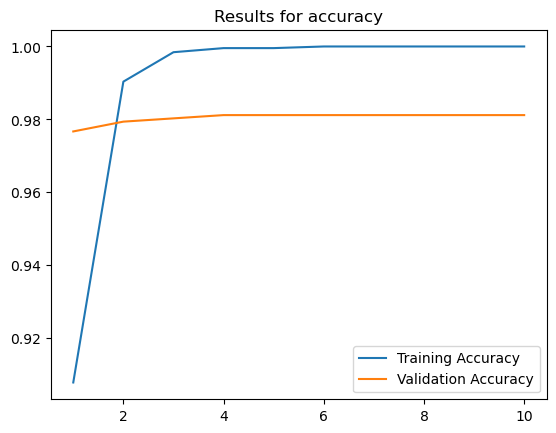

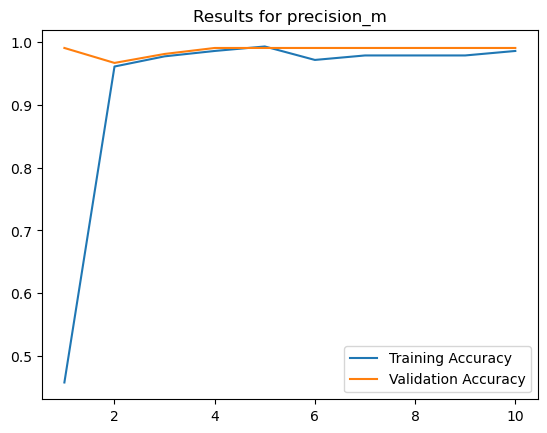

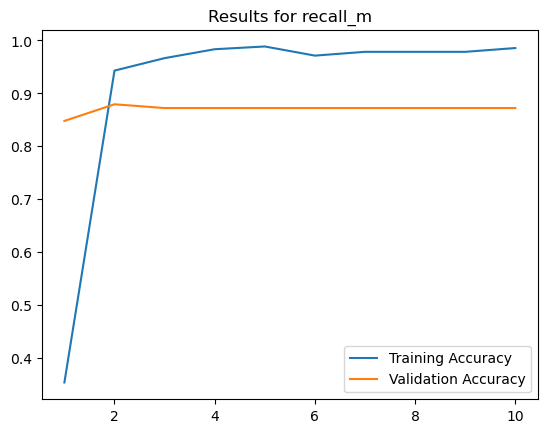

In [61]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

# Iterate over the metrics to plot their values
for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]                       # Training metric values
    val_acc = history.history['val_{}'.format(i)]  # Validation metric values
    epochs = range(1, len(acc) + 1)                # Range of epoch numbers

    plt.figure()                                            # Create a new figure for each plot
    plt.plot(epochs, acc, label='Training Accuracy')        # Plot training metric values
    plt.plot(epochs, val_acc, label='Validation Accuracy')  # Plot validation metric values
    plt.title('Results for {}'.format(i))                   # Set plot title
    plt.legend()                                            # Add a legend to the plot
    plt.show()                                              # Display the plot

As I mentioned before, this is useful to see how many epochs are really needed, and if we're under fitting or over fitting. Your training accuracy will always improve at each epoch, but what we really care about is whether the validation metrics are improving with each epoch. And as we saw in the chapter on RNNs, it's not really improving as we add additional epochs, so we probably could've cut this short. With the amount of data that we're training on, it doesn't make a huge difference because this train's pretty fast. But if you're talking about millions of rows of data, you don't want to be training 10 epochs when you could get away with two epochs. 

## Conclusion

<center>
    <img src="images/compare.png" width="900" />
</center>

Now, this is an important case study in how you weight performance and precision versus recall. On the surface, the RNN has better recall and accuracy, so the slight drop in precision relative to TF-IDF is tolerable. However, model selection really depends on the problem you're trying to solve and the cost of different types of errors. 

For instance, on a problem like **fraud detection**, you should optimize for *recall* because you don't want to miss any real fraud. But for a problem like **spam filtering**, you should optimize for *precision*. In other words, I can handle the model allowing some spam into my inbox, but if it classifies a real message as spam, and I never see it, I won't be happy. So we should optimize for precision here, and with 100% precision, it's hard to beat TF-IDF. And with the relative simplicity of that TF-IDF model, I would probably choose that model for the spam filtering task.